# Example 8: RVT SRA with simulated profiles

Use RVT with simulated profiles to compute the surface response spectrum and surface spectral ratio.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams['figure.dpi'] = 120

## Create a point source theory RVT motion

In [3]:
m = pysra.motion.SourceTheoryRvtMotion(6.0, 30, 'wna')
m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [32]:
profile = pysra.site.Profile([
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=100), 10, 400),
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=200), 10, 450),
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=400), 30, 600),
    pysra.site.Layer(
        pysra.site.SoilType('Rock', 24., None, 0.01), 0, 1200),
])

## Create the site response calculator

In [33]:
calc = pysra.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [34]:
var_thickness = pysra.variation.ToroThicknessVariation()
var_velocity = pysra.variation.ToroVelocityVariation.generic_model(
    'USGS C')
var_soiltypes = pysra.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30)

## Specify the output

In [35]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection([
    pysra.output.ResponseSpectrumOutput(
        # Frequency
        freqs,
        # Location of the output
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.ResponseSpectrumRatioOutput(
        # Frequency
        freqs,
        # Location in (denominator),
        pysra.output.OutputLocation('outcrop', index=-1),
        # Location out (numerator)
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.InitialVelProfile(),
])

## Perform the calculation

In [36]:
count = 100
for p in pysra.variation.iter_varied_profiles(
        profile,
        count,
        var_thickness=var_thickness,
        var_velocity=var_velocity,
        var_soiltypes=var_soiltypes
):
    # Here we auto-descretize the profile for wave propagation purposes
    calc(m, p.auto_discretize(), p.location('outcrop', index=-1))
    outputs(calc)

## Plot the outputs

Create a few plots of the output.

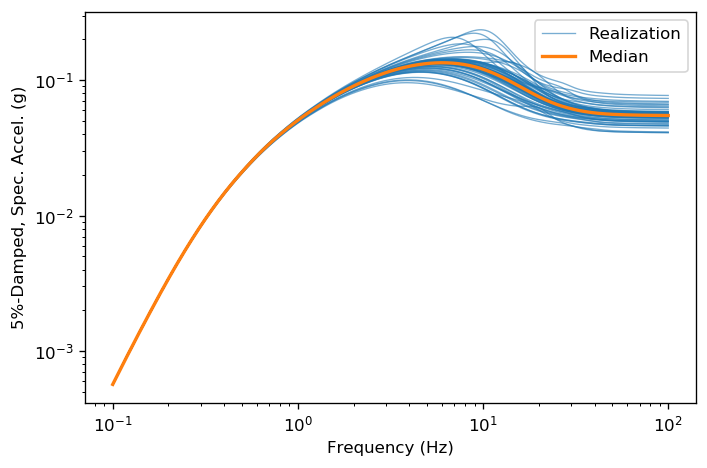

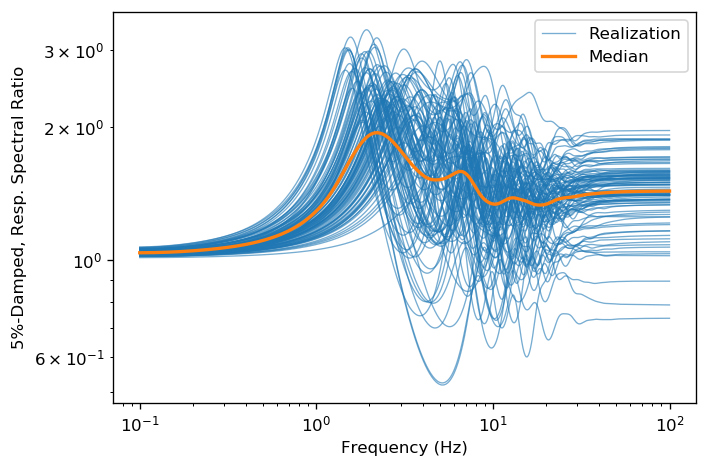

In [37]:
for o in outputs[:-1]:
    fig, ax = o.plot()
    fig;

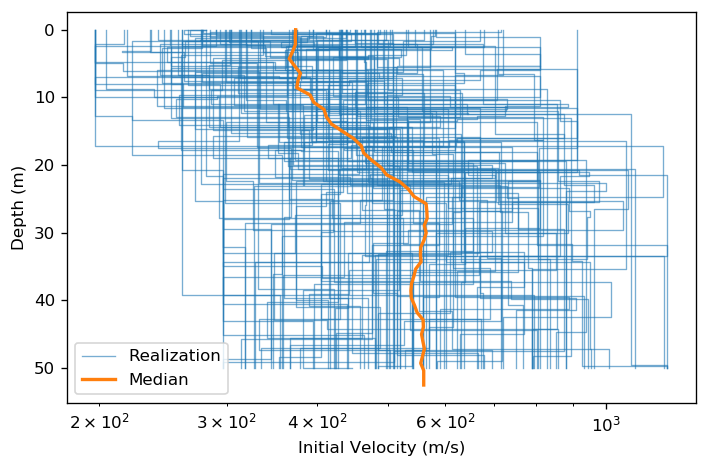

In [38]:
fig, ax = outputs[-1].plot()

The statistics of the output can be also retrieved and returned as either a `dict` or `pandas.DataFrame`.

In [39]:
outputs[-1].calc_stats()

{'ref': array([ 0.        ,  1.07142857,  2.14285714,  3.21428571,  4.28571429,
         5.35714286,  6.42857143,  7.5       ,  8.57142857,  9.64285714,
        10.71428571, 11.78571429, 12.85714286, 13.92857143, 15.        ,
        16.07142857, 17.14285714, 18.21428571, 19.28571429, 20.35714286,
        21.42857143, 22.5       , 23.57142857, 24.64285714, 25.71428571,
        26.78571429, 27.85714286, 28.92857143, 30.        , 31.07142857,
        32.14285714, 33.21428571, 34.28571429, 35.35714286, 36.42857143,
        37.5       , 38.57142857, 39.64285714, 40.71428571, 41.78571429,
        42.85714286, 43.92857143, 45.        , 46.07142857, 47.14285714,
        48.21428571, 49.28571429, 50.35714286, 51.42857143, 52.5       ]),
 'median': array([373.34036061, 372.87907783, 373.17856611, 369.7976328 ,
        365.79870438, 372.22426591, 379.04871551, 376.12892006,
        374.73311664, 390.94773149, 395.33885584, 408.60480323,
        411.47535662, 418.27521535, 433.03512252, 448.75533

In [40]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,373.340361,0.339058
1.071429,372.879078,0.340202
2.142857,373.178566,0.338105
3.214286,369.797633,0.340435
4.285714,365.798704,0.338862
5.357143,372.224266,0.348611
6.428571,379.048716,0.359432
7.500000,376.128920,0.341790
8.571429,374.733117,0.337488


## Repeat using a Generic Depth-Dependent Model

The generic `DepthDependToroVelVariation` follows the SPID guidance.

In [46]:
var_velocity_dd = pysra.variation\
    .DepthDependToroVelVariation.generic_model('USGS C')

In [47]:
outputs.reset()
count = 100
for p in pysra.variation.iter_varied_profiles(
        profile,
        count,
        var_thickness=var_thickness,
        var_velocity=var_velocity_dd,
        var_soiltypes=var_soiltypes
):
    calc(m, p.auto_discretize(), p.location('outcrop', index=-1))
    outputs(calc)

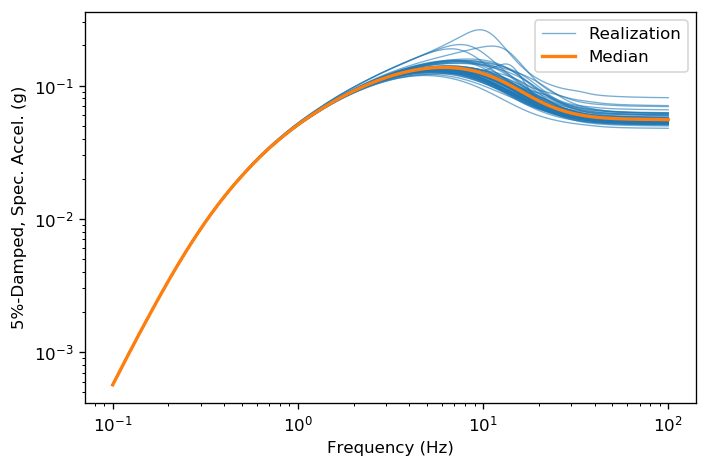

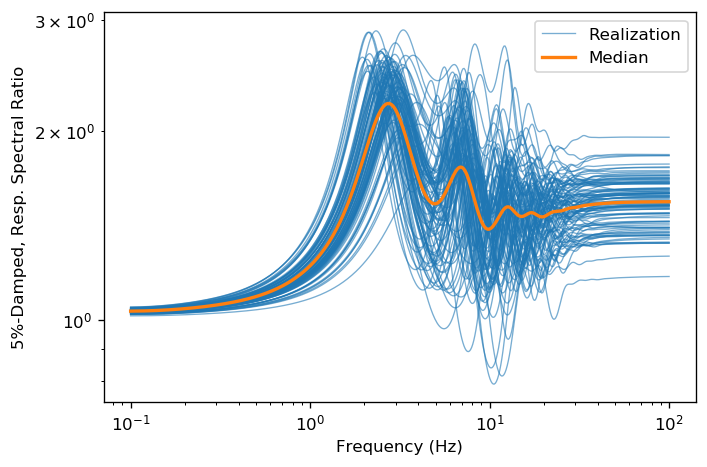

In [48]:
for o in outputs[:-1]:
    fig, ax = o.plot()
    fig;

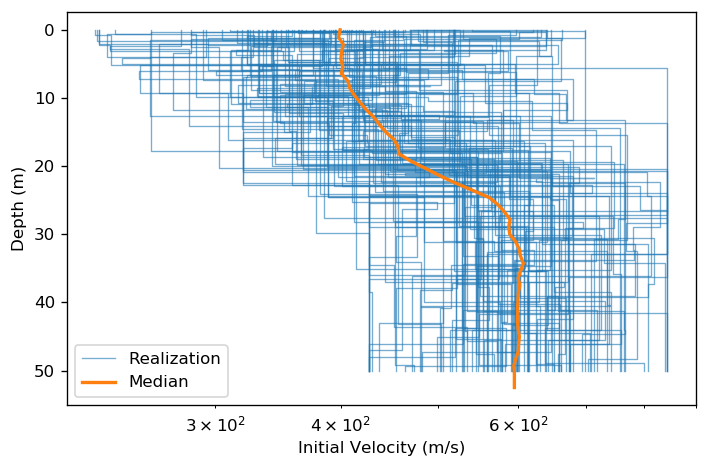

In [49]:
fig, ax = outputs[-1].plot()

In [50]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,399.392097,0.239551
1.071429,397.979832,0.243281
2.142857,402.244873,0.255155
3.214286,400.844742,0.243488
4.285714,400.075491,0.241622
5.357143,401.824114,0.235165
6.428571,400.644872,0.232580
7.500000,406.578558,0.231696
8.571429,408.429990,0.229705


## Repeat using a Specific Depth-Dependent Model

In [52]:
var_velocity_dd = pysra.variation\
    .DepthDependToroVelVariation.generic_model(
    'USGS C',
    depth=[0, 10, 20],
    ln_std=[0.25, 0.15, 0.10]
)

In [53]:
outputs.reset()
count = 100
for p in pysra.variation.iter_varied_profiles(
        profile,
        count,
        var_thickness=var_thickness,
        var_velocity=var_velocity_dd,
        var_soiltypes=var_soiltypes
):
    calc(m, p.auto_discretize(), p.location('outcrop', index=-1))
    outputs(calc)

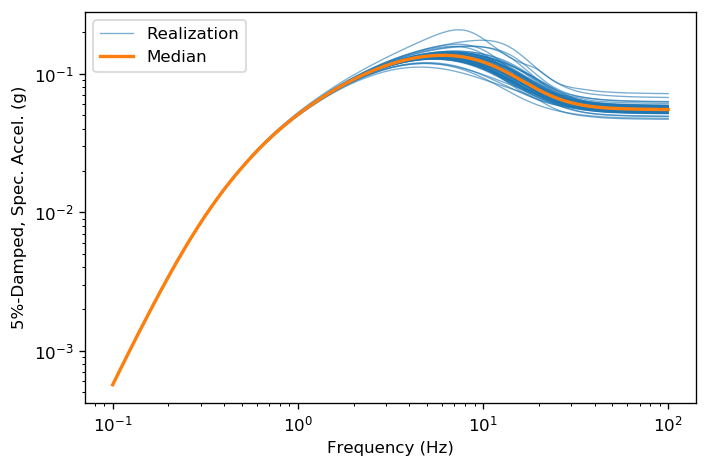

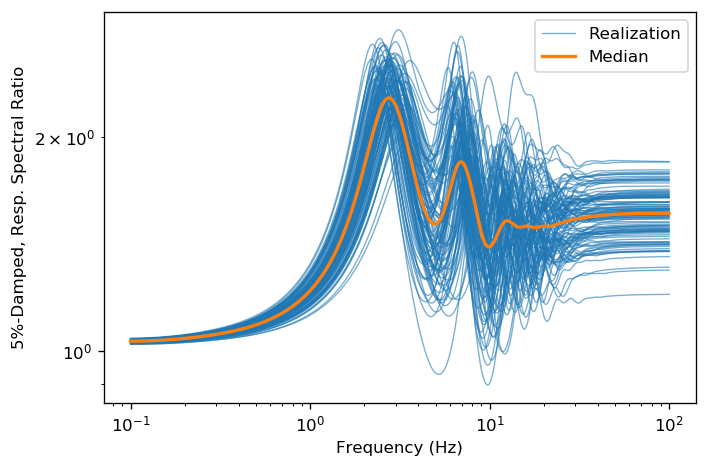

In [54]:
for o in outputs[:-1]:
    fig, ax = o.plot()
    fig;

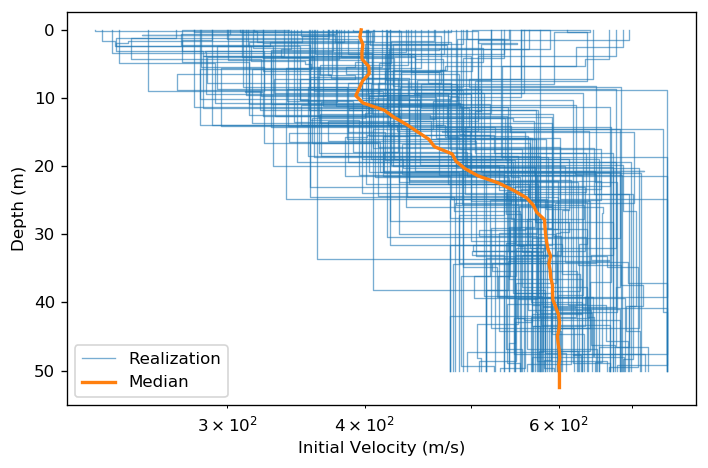

In [55]:
fig, ax = outputs[-1].plot()

In [56]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,396.999087,0.255808
1.071429,395.981772,0.262840
2.142857,398.456891,0.266753
3.214286,397.655776,0.264037
4.285714,397.683968,0.240930
5.357143,403.419107,0.225696
6.428571,403.730887,0.206469
7.500000,398.147512,0.209016
8.571429,395.482335,0.204792
